In [24]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.models import load_model, save_model
from keras.utils import get_file, to_categorical
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('..\..\CSV\KDDCUP99\kdd-with-columns.csv')

# For now, just drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1)

df['outcome'] = df['outcome'].apply(lambda x: x.rstrip('.'))


In [26]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal


## Analyzing a Dataset

In [27]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,\
                int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [28]:
df.groupby('outcome')['outcome'].count()

outcome
back                 2203
buffer_overflow        30
ftp_write               8
guess_passwd           53
imap                   12
ipsweep              1247
land                   21
loadmodule              9
multihop                7
neptune            107201
nmap                  231
normal              97278
perl                    3
phf                     4
pod                   264
portsweep            1040
rootkit                10
satan                1589
smurf              280790
spy                     2
teardrop              979
warezclient          1020
warezmaster            20
Name: outcome, dtype: int64

In [29]:
analyze(df)


494021 rows
** duration:2495 (0%)
** protocol_type:[icmp:57.41%,tcp:38.47%,udp:4.12%]
** service:[ecr_i:56.96%,private:22.45%,http:13.01%,smtp:1.97%,other:1.46%,domain_u:1.19%,ftp_data:0.96%,eco_i:0.33%,ftp:0.16%,finger:0.14%,urp_i:0.11%,telnet:0.1%,ntp_u:0.08%,auth:0.07%,pop_3:0.04%,time:0.03%,csnet_ns:0.03%,remote_job:0.02%,gopher:0.02%,imap4:0.02%,discard:0.02%,domain:0.02%,iso_tsap:0.02%,systat:0.02%,shell:0.02%,echo:0.02%,rje:0.02%,whois:0.02%,sql_net:0.02%,printer:0.02%,nntp:0.02%,courier:0.02%,sunrpc:0.02%,netbios_ssn:0.02%,mtp:0.02%,vmnet:0.02%,uucp_path:0.02%,uucp:0.02%,klogin:0.02%,bgp:0.02%,ssh:0.02%,supdup:0.02%,nnsp:0.02%,login:0.02%,hostnames:0.02%,efs:0.02%,daytime:0.02%,link:0.02%,netbios_ns:0.02%,pop_2:0.02%,ldap:0.02%,netbios_dgm:0.02%,exec:0.02%,http_443:0.02%,kshell:0.02%,name:0.02%,ctf:0.02%,netstat:0.02%,Z39_50:0.02%,IRC:0.01%,urh_i:0.0%,X11:0.0%,tim_i:0.0%,pm_dump:0.0%,tftp_u:0.0%,red_i:0.0%]
** flag:[SF:76.6%,S0:17.61%,REJ:5.44%,RSTR:0.18%,RSTO:0.12%,SH:0.02%,S

## Encode the feature vector

In [30]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],
# [0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


In [31]:
# # Now encode the feature vector

# for name in df.columns:
#   if name == 'outcome':
#     pass
#   elif name in ['protocol_type','service','flag','land','logged_in','is_host_login','is_guest_login']:
#     encode_text_dummy(df,name)
#   else:
#     encode_numeric_zscore(df,name)    

# pd.set_option('display.max_columns', 100)

# df.dropna(inplace=True,axis=1)
# df[0:5]

# # Convert to numpy - Classification
# x_columns = df.columns.drop('outcome')
# x = df[x_columns].values
# dummies = pd.get_dummies(df['outcome']) # Classification
# outcomes = dummies.columns
# num_classes = len(outcomes)
# y = dummies.values

In [32]:
# y_df = pd.DataFrame(y, columns=outcomes)
# y_df

In [33]:
df.loc[df['protocol_type']=='tcp', 'protocol_type'] =1
df.loc[df['protocol_type']=='udp', 'protocol_type'] =2
df.loc[df['protocol_type']=='icmp', 'protocol_type']=3

In [34]:
df.loc[df['flag']== 'SF', 'flag'] = 1
df.loc[df['flag']== 'S0', 'flag'] = 2
df.loc[df['flag']== 'REJ', 'flag'] = 3
df.loc[df['flag']== 'RSTR', 'flag'] = 4
df.loc[df['flag']== 'SH', 'flag'] = 5
df.loc[df['flag']== 'RSTO', 'flag'] = 6
df.loc[df['flag']== 'S1', 'flag'] = 7
df.loc[df['flag']== 'RSTOS0', 'flag'] = 8
df.loc[df['flag']== 'S3', 'flag'] = 9
df.loc[df['flag']== 'S2', 'flag'] = 10
df.loc[df['flag']== 'OTH', 'flag'] = 11

In [35]:
df.loc[df['outcome']=='buffer_overflow', 'outcome'] = 'other attack'
df.loc[df['outcome']=='ftp_write', 'outcome'] = 'other attack'
df.loc[df['outcome']=='imap', 'outcome'] = 'other attack'
df.loc[df['outcome']=='land', 'outcome'] = 'other attack'
df.loc[df['outcome']=='loadmodule', 'outcome'] = 'other attack'
df.loc[df['outcome']=='multihop', 'outcome'] = 'other attack'
df.loc[df['outcome']=='perl', 'outcome'] = 'other attack'
df.loc[df['outcome']=='phf', 'outcome'] = 'other attack'
df.loc[df['outcome']=='rootkit', 'outcome'] = 'other attack'
df.loc[df['outcome']=='spy', 'outcome'] = 'other attack'
df.loc[df['outcome']=='warezmaster', 'outcome'] = 'other attack'
df.loc[df['outcome']=='back', 'outcome'] = 'other attack'


In [36]:
df.groupby('outcome')['outcome'].count()

outcome
guess_passwd        53
ipsweep           1247
neptune         107201
nmap               231
normal           97278
other attack      2329
pod                264
portsweep         1040
satan             1589
smurf           280790
teardrop           979
warezclient       1020
Name: outcome, dtype: int64

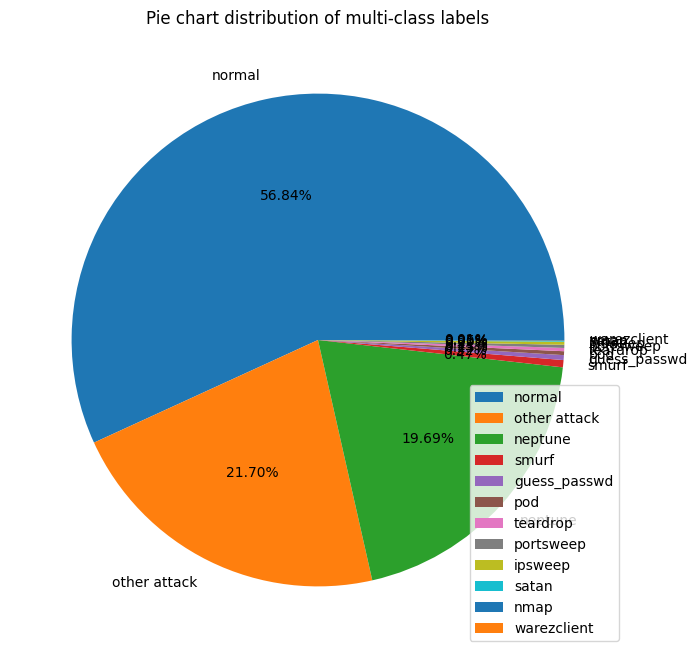

In [37]:
plt.figure(figsize=(8,8))
plt.pie(df.outcome.value_counts(),labels=df.outcome.unique(),autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend(loc='best')
# plt.savefig('plots/Pie_chart_multi.png')
plt.show()

In [38]:
pd.set_option('display.max_columns', 100)

x = df[['protocol_type','flag','src_bytes','dst_bytes','hot','count','srv_count','same_srv_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_rerror_rate']]

In [39]:
x

,protocol_type,flag,src_bytes,dst_bytes,hot,count,srv_count,same_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_rerror_rate
0,1,1,181,5450,0,8,8,1.0,9,9,1.0,0.0,0.11,0.0
1,1,1,239,486,0,8,8,1.0,19,19,1.0,0.0,0.05,0.0
2,1,1,235,1337,0,8,8,1.0,29,29,1.0,0.0,0.03,0.0
3,1,1,219,1337,0,6,6,1.0,39,39,1.0,0.0,0.03,0.0
4,1,1,217,2032,0,6,6,1.0,49,49,1.0,0.0,0.02,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,1,1,310,1881,0,4,5,1.0,86,255,1.0,0.0,0.01,0.0
494017,1,1,282,2286,0,6,6,1.0,6,255,1.0,0.0,0.17,0.0
494018,1,1,203,1200,0,6,18,1.0,16,255,1.0,0.0,0.06,0.0
494019,1,1,291,1200,0,6,12,1.0,26,255,1.0,0.0,0.04,0.0


In [40]:
# for name in x.columns:
#   if name == 'outcome':
#     pass
#   elif name in ['protocol_type','service','flag','land','logged_in','is_host_login','is_guest_login']:
#     encode_text_dummy(x,name)
#   else:
#     encode_numeric_zscore(x,name)    

In [41]:
# x_columns = x.columns.drop('outcome')
# x = x[x_columns].values

y = df['outcome']

oversample = SMOTE(k_neighbors=2)
x,y = oversample.fit_resample(x,y)
print('Classes and number of values in trainset after SMOTE:',Counter(y))

dummies = pd.get_dummies(y)
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values
y_df = pd.DataFrame(y, columns=outcomes)
y_df

Classes and number of values in trainset after SMOTE: Counter({'normal': 280790, 'other attack': 280790, 'neptune': 280790, 'smurf': 280790, 'guess_passwd': 280790, 'pod': 280790, 'teardrop': 280790, 'portsweep': 280790, 'ipsweep': 280790, 'satan': 280790, 'nmap': 280790, 'warezclient': 280790})


,guess_passwd,ipsweep,neptune,nmap,normal,other attack,pod,portsweep,satan,smurf,teardrop,warezclient
0,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3369475,False,False,False,False,False,False,False,False,False,False,False,True
3369476,False,False,False,False,False,False,False,False,False,False,False,True
3369477,False,False,False,False,False,False,False,False,False,False,False,True
3369478,False,False,False,False,False,False,False,False,False,False,False,True


In [42]:
outcomes

Index(['guess_passwd', 'ipsweep', 'neptune', 'nmap', 'normal', 'other attack',
       'pod', 'portsweep', 'satan', 'smurf', 'teardrop', 'warezclient'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


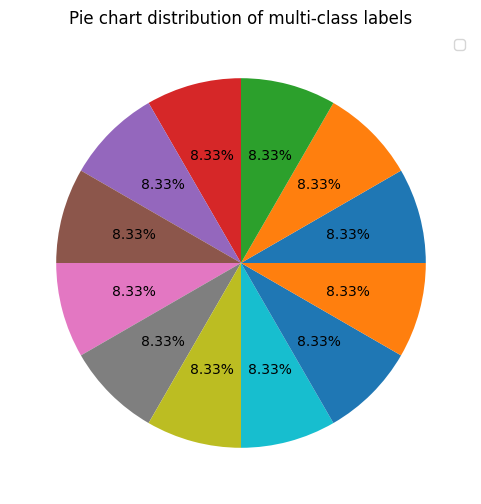

In [46]:
plt.figure(figsize=(6,6))
plt.pie(y_df.value_counts(),autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend(loc='best')
# plt.savefig('plots/Pie_chart_multi.png')
plt.show()

## Train the Neural Network

In [38]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2,epochs=25)
        

Epoch 1/25
84237/84237 - 159s - loss: 0.9854 - val_loss: 0.5673 - 159s/epoch - 2ms/step
Epoch 2/25
84237/84237 - 157s - loss: 0.6852 - val_loss: 0.4299 - 157s/epoch - 2ms/step
Epoch 3/25
84237/84237 - 160s - loss: 0.4988 - val_loss: 0.4511 - 160s/epoch - 2ms/step
Epoch 4/25
84237/84237 - 175s - loss: 0.4311 - val_loss: 0.3421 - 175s/epoch - 2ms/step
Epoch 5/25
84237/84237 - 169s - loss: 1.2799 - val_loss: 0.4630 - 169s/epoch - 2ms/step
Epoch 6/25
84237/84237 - 164s - loss: 0.5730 - val_loss: 0.4684 - 164s/epoch - 2ms/step
Epoch 7/25
84237/84237 - 163s - loss: 0.4471 - val_loss: 0.3045 - 163s/epoch - 2ms/step
Epoch 8/25
84237/84237 - 165s - loss: 0.4657 - val_loss: 0.2681 - 165s/epoch - 2ms/step
Epoch 9/25
84237/84237 - 161s - loss: 0.3594 - val_loss: 0.3082 - 161s/epoch - 2ms/step
Epoch 10/25
84237/84237 - 159s - loss: 0.5111 - val_loss: 0.3736 - 159s/epoch - 2ms/step
Epoch 11/25
84237/84237 - 158s - loss: 0.3773 - val_loss: 0.3833 - 158s/epoch - 2ms/step
Epoch 12/25
84237/84237 - 157s

In [39]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

21060/21060 [==============================] - 30s 1ms/step
Validation score: 0.9360479955364033


In [40]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

report = classification_report(y_test, y_pred)
print(report)

21060/21060 [==============================] - 26s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     56037
           1       0.93      0.90      0.92     55944
           2       0.99      1.00      0.99     56358
           3       0.90      0.94      0.92     56148
           4       0.99      0.90      0.94     56369
           5       0.69      0.98      0.81     55778
           6       0.91      0.98      0.94     56014
           7       1.00      0.98      0.99     56574
           8       1.00      0.98      0.99     56131
           9       1.00      1.00      1.00     56192
          10       0.99      1.00      0.99     56180
          11       0.97      0.58      0.73     56171

    accuracy                           0.94    673896
   macro avg       0.95      0.94      0.93    673896
weighted avg       0.95      0.94      0.93    673896



In [41]:
save_model(model, 'kddDnnFinal.h5')

with open('outcomesFinal.pkl', 'wb') as f:
    pickle.dump(outcomes, f)
# # loaded_model = load_model('kddDnn.h5')

In [42]:
# import tensorflow as tf
# print(tf.__version__)

# import keras
# print(keras.__version__)

# import sys
# print(sys.version)